In [ ]:
# Matteo's version of the plotting
reload(do)
dt=1e-2
import matplotlib.animation as animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 1000)
line, = ax.plot(system.grid, do.eval_one_body_density(system, nparticles, C0).real)
integrator = scipy.integrate.ode(rhs.f).set_integrator('zvode')
integrator.set_initial_value( np.reshape(C0, len(C0)**2 ), 0)
ani = animation.FuncAnimation(fig, do.animation, fargs=(line, system, dt, t_max, C0, omega, epsilon0, nparticles, integrator), interval=200, blit=True, save_count=1000)
from IPython.display import HTML
HTML(ani.to_jshtml())

In [75]:
%reset

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do2
from importlib import reload
from IPython.display import display, clear_output
from quantum_systems import ODQD, GeneralOrbitalSystem

In [141]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25*4  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

In [142]:
reload(do2)
dt = 1e-3
T = 7 * 2*np.pi/omega
ghf = do2.GHF(Omega=Omega, omega=omega)

Converged
C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


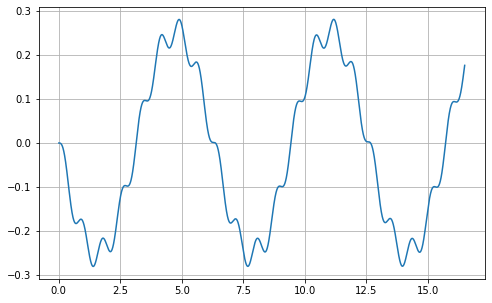

In [143]:
reload(do2)
epsilon, C0 = ghf.solve_TIHF(tolerance=1e-6, max_iter=1000, print_ON=True, energy_per_step_ON=False)
C1, time1, dipole1 = ghf.solve_TDHF(0, dt, 3*T, C0, eval_overlap=False, eval_dipole=True, laser_ON=True)
ghf.plot_dipole(time1, dipole1)

C:\Users\Utente\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


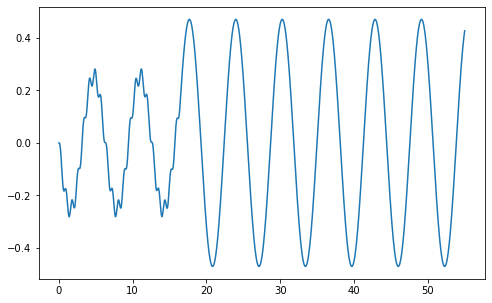

In [144]:
reload(do2)
C2, time2, dipole2 = ghf.solve_TDHF(3*T,  dt, 10*T, C1, eval_overlap=False, eval_dipole=True, laser_ON=False)

time = np.concatenate((time1,time2))
dipole = np.concatenate((dipole1, dipole2))

(0.0, 3.0)

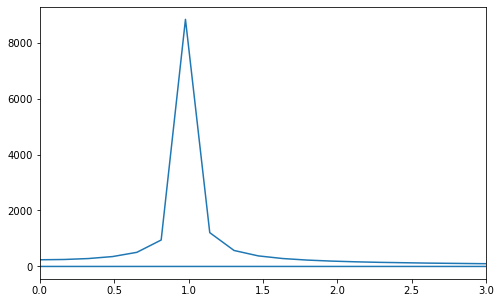

In [145]:
signalFFT = np.fft.fft(dipole2)
freqFFT = np.fft.fftfreq(len(dipole2), dt)
plt.figure(figsize=(8,5))
plt.plot(2*np.pi*freqFFT, np.abs(signalFFT))
plt.xlim([0, 3])

In [ ]:
time2.shape